In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text  # A dependency of the preprocessing model
from official.nlp import optimization
from jcarbon.tensorflow.callbacks import JCarbonEpochCallback, JCarbonBatchCallback

import numpy as np
import pandas as pd
import tensorflow_addons as tfa
import keras
import time

tf.get_logger().setLevel('ERROR')

2024-05-16 16:07:10.532350: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 16:07:10.577931: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-16 16:07:10.577954: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-16 16:07:10.579193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-16 16:07:10.585921: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-16 16:07:10.586609: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
#add bert model
bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [3]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [4]:
test_preprocess_model = make_bert_preprocess_model(['my_input1', 'my_input2'])
test_text = [np.array(['some random test sentence']),
             np.array(['another sentence'])]
text_preprocessed = test_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_mask', 'input_type_ids', 'input_word_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[ 101 2070 6721 3231 6251  102 2178 6251  102    0    0    0    0    0
    0    0], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [5]:
AUTOTUNE = tf.data.AUTOTUNE


def load_dataset_from_tfds(in_memory_ds, info, split, batch_size,
                           bert_preprocess_model):
    is_training = split.startswith('train')
    dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[split])
    num_examples = info.splits[split].num_examples

  # dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    # iterator = iter(dataset)
    # while True:
    #     try:
    #         _ = next(iterator)
    #     except tf.errors.OutOfRangeError:
    #         break
    for _ in dataset:
        pass
    dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)
    if is_training:
        dataset = dataset.shuffle(num_examples)
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(lambda ex: (bert_preprocess_model(ex), ex['label']))
  
    return dataset, num_examples

In [6]:
def build_classifier_model(num_classes):

  class Classifier(tf.keras.Model):
    def __init__(self, num_classes):
      super(Classifier, self).__init__(name="prediction")
      self.encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True)
      self.dropout = tf.keras.layers.Dropout(0.1)
      self.dense = tf.keras.layers.Dense(num_classes)

    def call(self, preprocessed_text):
      encoder_outputs = self.encoder(preprocessed_text)
      pooled_output = encoder_outputs["pooled_output"]
      x = self.dropout(pooled_output)
      x = self.dense(x)
      return x

  model = Classifier(num_classes)
  return model

In [7]:
text_classifier_model = build_classifier_model(2)
bert_raw_result = text_classifier_model(text_preprocessed)
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.7349331  0.14189844]], shape=(1, 2), dtype=float32)


In [8]:
tfds_name = 'glue/cola' 

tfds_info = tfds.builder(tfds_name).info

sentence_features = list(tfds_info.features.keys())
sentence_features.remove('idx')
sentence_features.remove('label')

available_splits = list(tfds_info.splits.keys())
train_split = 'train'
validation_split = 'validation'
test_split = 'test'
if tfds_name == 'glue/mnli':
  validation_split = 'validation_matched'
  test_split = 'test_matched'

num_classes = tfds_info.features['label'].num_classes
num_examples = tfds_info.splits.total_num_examples

print(f'Using {tfds_name} from TFDS')
print(f'This dataset has {num_examples} examples')
print(f'Number of classes: {num_classes}')
print(f'Features {sentence_features}')
print(f'Splits {available_splits}')

with tf.device('/job:localhost'):
  # batch_size=-1 is a way to load the dataset into memory
  in_memory_ds = tfds.load(tfds_name, batch_size=-1, shuffle_files=True)

# The code below is just to show some samples from the selected dataset
print(f'Here are some sample rows from {tfds_name} dataset')
sample_dataset = tf.data.Dataset.from_tensor_slices(in_memory_ds[train_split])

labels_names = tfds_info.features['label'].names
print(labels_names)
print()

sample_i = 1
for sample_row in sample_dataset.take(5):
  samples = [sample_row[feature] for feature in sentence_features]
  print(f'sample row {sample_i}')
  for sample in samples:
    print(sample.numpy())
  sample_label = sample_row['label']

  print(f'label: {sample_label} ({labels_names[sample_label]})')
  print()
  sample_i += 1

Using glue/cola from TFDS
This dataset has 10657 examples
Number of classes: 2
Features ['sentence']
Splits ['train', 'validation', 'test']
Here are some sample rows from glue/cola dataset
['unacceptable', 'acceptable']

sample row 1
b'It is this hat that it is certain that he was wearing.'
label: 1 (acceptable)

sample row 2
b'Her efficient looking up of the answer pleased the boss.'
label: 1 (acceptable)

sample row 3
b'Both the workers will wear carnations.'
label: 1 (acceptable)

sample row 4
b'John enjoyed drawing trees for his syntax homework.'
label: 1 (acceptable)

sample row 5
b'We consider Leslie rather foolish, and Lou a complete idiot.'
label: 1 (acceptable)



In [9]:
def get_configuration(glue_task):

  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  if glue_task == 'glue/cola':
    metrics = tfa.metrics.MatthewsCorrelationCoefficient(num_classes=2)
  else:
    metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

  return metrics, loss

In [10]:
#loading datasets
batch_size = 2

print(f'Fine tuning {tfhub_handle_encoder} model')
bert_preprocess_model = make_bert_preprocess_model(sentence_features)

train_ds, train_ds_size = load_dataset_from_tfds(
       in_memory_ds, tfds_info, train_split, batch_size, bert_preprocess_model)


val_ds, val_ds_size = load_dataset_from_tfds(
      in_memory_ds, tfds_info, validation_split, batch_size,
      bert_preprocess_model)

validation_steps = val_ds_size // batch_size


Fine tuning https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1 model


/home/vincent/jCarbon_eevee/jcarbon/myenv/lib/python3.9/site-packages/keras/src/engine/functional.py:642: UserWarning: Input dict contained keys ['idx', 'label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [11]:
#create loss function
metrics, loss = get_configuration(tfds_name)

In [12]:
#create finetuning/optimizer
epochs = 20
steps_per_epoch = train_ds_size #batch size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = 10

init_lr = 2e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [13]:
#load and train BERT
classifier_model = build_classifier_model(num_classes)
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [14]:
from jcarbon.client import JCarbonClient
from jcarbon.report import to_dataframe

DEFAULT_PERIOD_MS = 10
DEFAULT_SIGNALS = [
    'jcarbon.cpu.eflect.ProcessEnergy',
    'jcarbon.emissions.Emissions',
    'jcarbon.server.MonotonicTimestamp',
    'jcarbon.nvml.NvmlEstimatedEnergy',
    'jcarbon.nvml.NvmlTotalEnergy',
]

class JCarbonEpochCallback2(tf.keras.callbacks.Callback):
    def __init__(self, addr='localhost:8980', period_ms=DEFAULT_PERIOD_MS, signals=DEFAULT_SIGNALS):
        self.pid = os.getpid()
        self.period_ms = period_ms
        self.client = JCarbonClient(addr)
        self.signals = signals
        self.reports = []
        x = 1

    def on_epoch_begin(self, epoch, logs=None):
        self.time = time.time()
        self.chunks = []
        self.client.start(self.pid, self.period_ms)

    def on_train_batch_end(self, epoch, logs=None):
        curr = time.time()
        if(curr - self.time > 10):
            self.client.stop(self.pid)
            self.chunks.append(to_dataframe(
                self.client.read(self.pid, self.signals)))
            self.client.start(self.pid, self.period_ms)
            self.time = curr
            if logs is not None:
                for (signal, component, unit), df in self.chunks[-1].groupby(['signal', 'component', 'unit']):
                    # TODO: this should really not ignore negatives
                    logs[f'jcarbon-epoch-{signal}-{component}-{unit}'] = df[df > 0].sum()
                
    def on_epoch_end(self, epoch, logs=None):
        self.client.stop(self.pid)
        self.chunks.append(to_dataframe(
            self.client.read(self.pid, self.signals)))
        self.reports.append(pd.concat(self.chunks))
        print("Finished epoch ")
        if logs is not None:
            for (signal, component, unit), df in self.reports[-1].groupby(['signal', 'component', 'unit']):
                # TODO: this should really not ignore negatives
                logs[f'jcarbon-epoch-{signal}-{component}-{unit}'] = df[df > 0].sum()
    

In [15]:
print(f'Training model with {tfhub_handle_encoder}')
jcarb = JCarbonEpochCallback2(period_ms=4)

classifier_model.fit(x=train_ds,
                       validation_data=val_ds,
                       epochs=epochs,
                       steps_per_epoch=steps_per_epoch,
                       validation_steps=val_ds_size,
                       callbacks = jcarb)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/20
8551/8551 [==============================] - 372s 43ms/step - loss: 0.9836 - MatthewsCorrelationCoefficient: 0.0000e+00 - jcarbon-epoch-jcarbon.cpu.eflect.ProcessEnergy-process=2391354-JOULES: 693.9963 - jcarbon-epoch-jcarbon.emissions.Emissions-os=Linux-GRAMS_OF_CO2: 0.0780 - jcarbon-epoch-jcarbon.emissions.Emissions-process=2391354-GRAMS_OF_CO2: 0.0765 - val_loss: 0.9772 - val_MatthewsCorrelationCoefficient: 0.0000e+00
Epoch 2/20
8551/8551 [==============================] - 357s 42ms/step - loss: 0.9503 - MatthewsCorrelationCoefficient: 0.0000e+00 - jcarbon-epoch-jcarbon.cpu.eflect.ProcessEnergy-process=2391354-JOULES: 693.9008 - jcarbon-epoch-jcarbon.emissions.Emissions-os=Linux-GRAMS_OF_CO2: 0.0775 - jcarbon-epoch-jcarbon.emissions.Emissions-process=2391354-GRAMS_OF_CO2: 0.0765
Epoch 3/20
8551/8551 [==============================] - 357s 42ms/step - loss: 0.8907 - MatthewsCorrelat

In [16]:
jcarb.reports

[signal                            start                          end                            ts            component        unit          subcomponent                
 jcarbon.cpu.eflect.ProcessEnergy  2024-05-16 20:07:25.543646163  2024-05-16 20:07:25.548811475  4.766236e+15  process=2391354  JOULES        process=2391354:task=2391354    0.100751
                                   2024-05-16 20:07:25.548837028  2024-05-16 20:07:25.548875400  4.766236e+15  process=2391354  JOULES        process=2391354:task=2391354    0.000797
                                   2024-05-16 20:07:25.553941413  2024-05-16 20:07:25.558886312  4.766236e+15  process=2391354  JOULES        process=2391354:task=2391354    0.097938
                                   2024-05-16 20:07:25.558909593  2024-05-16 20:07:25.558943401  4.766236e+15  process=2391354  JOULES        process=2391354:task=2391354    0.000765
                                   2024-05-16 20:07:25.563849038  2024-05-16 20:07:25.568802675  

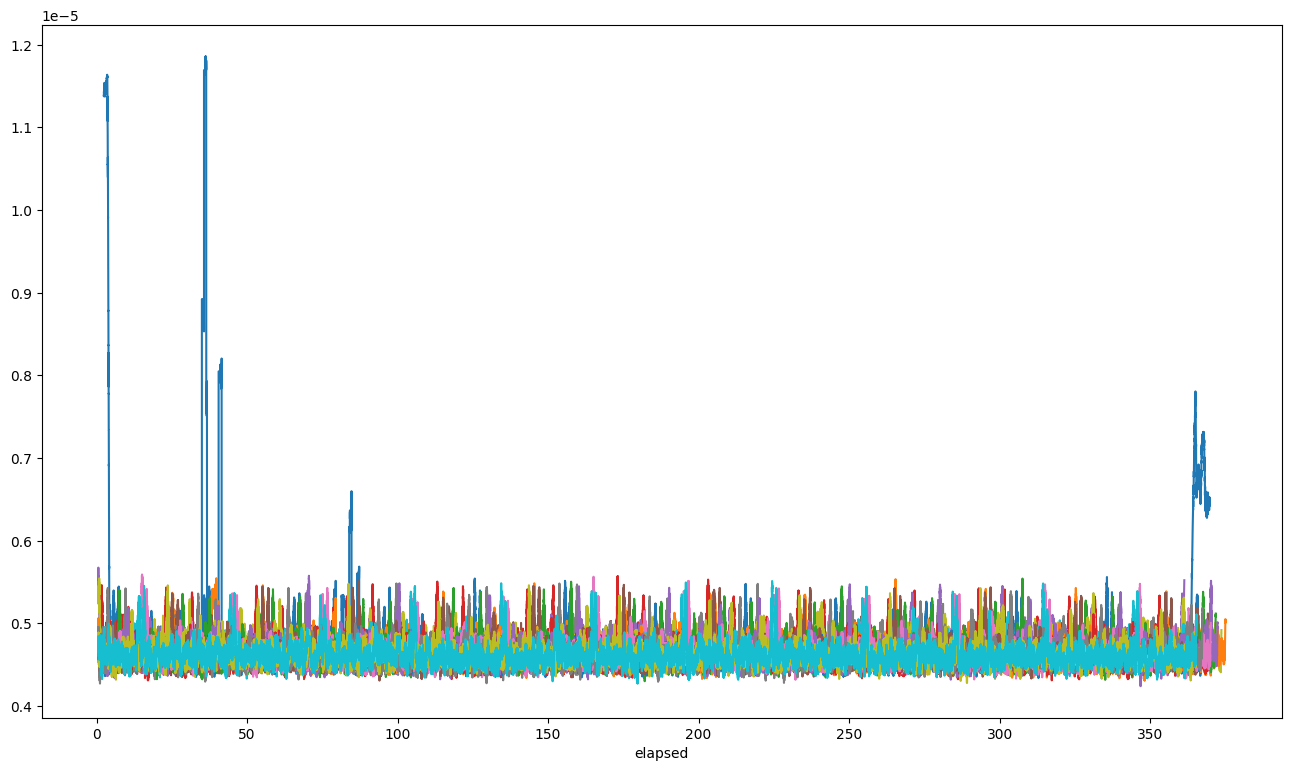

In [17]:
signal = 'jcarbon.emissions.Emissions'
ax=None
for report in jcarb.reports:
    df = report.reset_index()
    df = df[df.signal == signal]
    df = df[df['value'] > 0]
    df['elapsed'] = (df.start - df.start.min()).dt.total_seconds()
    df['rolled_value'] = df['value'].rolling(1000).mean()
    ax = df.plot(x='elapsed', y='rolled_value', legend=False, figsize=(16, 9), ax=ax)

<Axes: title={'center': 'glue/cola'}, xlabel='epoch', ylabel='emissions (grams of co2)'>

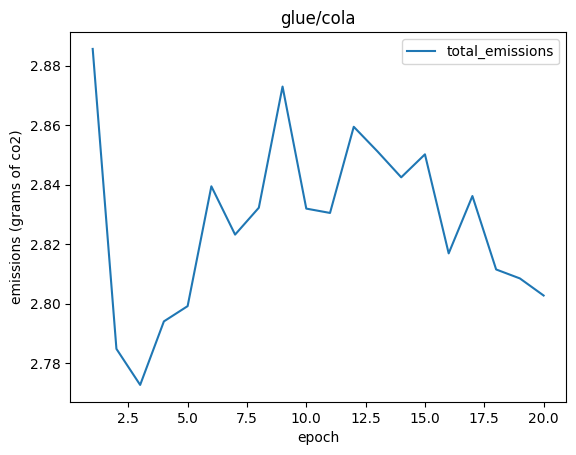

In [18]:
signal = 'jcarbon.emissions.Emissions'
x = 0
df = pd.DataFrame()

for report in jcarb.reports:
    df_temp = report.reset_index()
    df_temp = df_temp[df_temp.signal == signal]
    df_temp = df_temp[df_temp['value'] > 0]
    df_temp['epochs'] = x+1
    df_temp['total_emissions'] = df_temp['value'].sum()
    df = pd.concat([df_temp, df]) 
    x+=1
df.plot(x = 'epochs', y = 'total_emissions', xlabel = 'epoch', ylabel = 'emissions (grams of co2)', title = tfds_name)

In [ ]:
jcarb.reports[1].groupby(['signal', 'component']).sum()